## **CIFAR10 image classification**

### **1. Load the dataset/Preprocess the data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

def data_preprocessing(x, y):
  x = np.array(x/255.0, dtype=np.float32)
  y = np.array(y, dtype=np.float32)
  return x, y

def data_one_hot_encoding(x, y):
  x, y = data_preprocessing(x, y)
  y_ohe = to_categorical(y)
  return x, y_ohe

def get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42):
  train_x, train_y_ohe = data_one_hot_encoding(train_x, train_y)
  test_x, test_y_ohe = data_one_hot_encoding(test_x, test_y)
  train_x, valid_x, train_y_ohe, valid_y_ohe = train_test_split(train_x, train_y_ohe, test_size=valid_size, random_state=random_state)
  return (train_x, train_y_ohe), (valid_x, valid_y_ohe), (test_x, test_y_ohe)

In [ ]:
from tensorflow.keras.datasets import cifar10

set_random_seed(42)

(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### **2. Visualize the data**

In [ ]:
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(x, y, ncols=5):
  fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=ncols)
  for i in range(ncols):
    axs[i].axis('off')
    axs[i].imshow(x[i])
    y_label = y[i].squeeze()
    axs[i].set_title(f'{class_names[int(y_label)]}', fontsize=12)

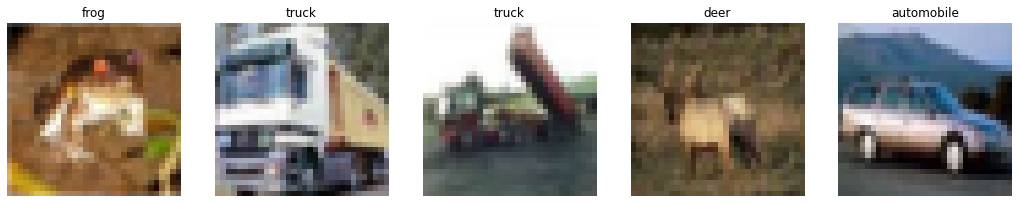

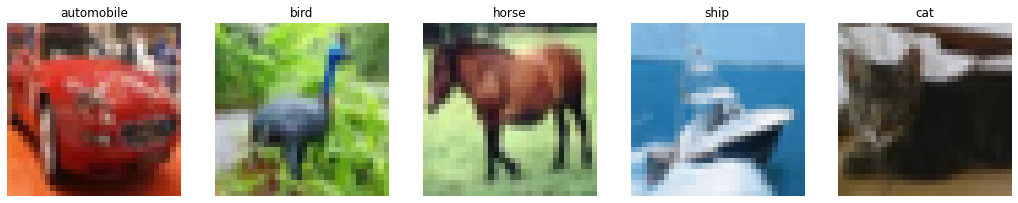

In [ ]:
show_images(train_x[:5], train_y[:5], ncols=5)
show_images(train_x[5:10], train_y[5:10], ncols=5)

In [ ]:
(train_x, train_y_ohe), (valid_x, valid_y_ohe), (test_x, test_y_ohe) = \
get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42)
print(train_x.shape, train_y_ohe.shape, valid_x.shape, valid_y_ohe.shape, test_x.shape, test_y_ohe.shape)

(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


### **3-1. Build the model : add new layers+strides2**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization

x_size = 32

input_tensor = Input(shape=(x_size, x_size, 3))
x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)
      
model_al_strides = Model(inputs=input_tensor, outputs=output)
model_al_strides.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

### **4-1. Compile/Train the model+callback**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model_al_strides.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.2, verbose=1)
cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

history = model_al_strides.fit(train_x, train_y_ohe, batch_size=32, epochs=50, shuffle=True,
                          validation_data=(valid_x, valid_y_ohe), callbacks=[cb_rlr, cb_esp])

Epoch 1/50
1329/1329 [==============================] - 26s 11ms/step - loss: 1.5193 - accuracy: 0.4542 - val_loss: 1.1750 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 14s 11ms/step - loss: 1.0688 - accuracy: 0.6253 - val_loss: 1.4734 - val_accuracy: 0.5431 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 16s 12ms/step - loss: 0.8874 - accuracy: 0.6933 - val_loss: 0.9750 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 14s 10ms/step - loss: 0.7693 - accuracy: 0.7390 - val_loss: 0.8975 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 14s 11ms/step - loss: 0.6757 - accuracy: 0.7736 - val_loss: 0.7230 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 14s 11ms/step - loss: 0.5864 - accuracy: 0.8060 - val_loss: 0.6615 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 7/50
1329/1329 [========================

In [ ]:
def show_history(history):
  fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  axs[0].plot(history.history['loss'], label='train_loss')
  axs[0].plot(history.history['val_loss'], label='val_loss')

  axs[1].plot(history.history['accuracy'], label='train_acc')
  axs[1].plot(history.history['val_accuracy'], label='val_acc')

  axs[0].legend()
  axs[0].set_xlabel('epochs', fontsize=12)
  axs[0].set_ylabel('loss', fontsize=12)

  axs[1].legend()
  axs[1].set_xlabel('epochs', fontsize=12)
  axs[1].set_ylabel('accuracy', fontsize=12)
  plt.show()

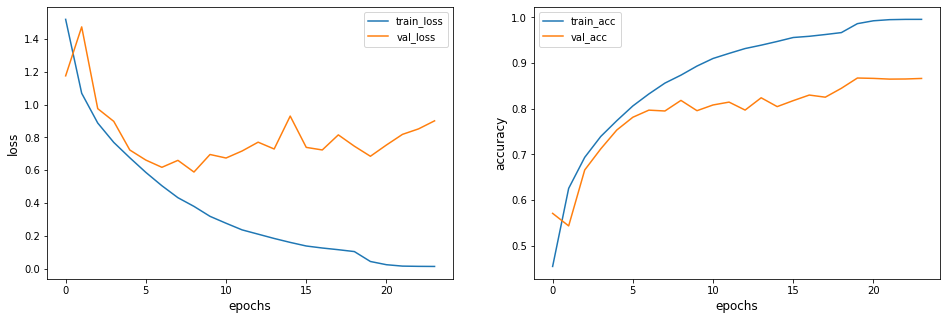

In [ ]:
show_history(history)

### **5-1. Evaluate the model**

In [ ]:
model_al_strides.evaluate(test_x, test_y_ohe)

313/313 [==============================] - 2s 5ms/step - loss: 0.8707 - accuracy: 0.8642


[0.8706507682800293, 0.8641999959945679]

### **3-2. Build the model : add new layers+GlobalAveragePooling2D**

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

x_size = 32

input_tensor = Input(shape=(x_size, x_size, 3))
x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)
      
model_al_gap = Model(inputs=input_tensor, outputs=output)
model_al_gap.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                           

### **4-2. Compile/Train the model+callback**

In [ ]:
model_al_gap.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.2, verbose=1)
cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

history = model_al_gap.fit(train_x, train_y_ohe, batch_size=32, epochs=50, shuffle=True,
                          validation_data=(valid_x, valid_y_ohe), callbacks=[cb_rlr, cb_esp])

Epoch 1/50
1329/1329 [==============================] - 15s 11ms/step - loss: 1.4273 - accuracy: 0.4780 - val_loss: 1.2112 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 14s 10ms/step - loss: 0.9768 - accuracy: 0.6577 - val_loss: 0.9972 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 14s 10ms/step - loss: 0.7870 - accuracy: 0.7280 - val_loss: 0.8272 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 14s 10ms/step - loss: 0.6562 - accuracy: 0.7752 - val_loss: 0.8269 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 13s 10ms/step - loss: 0.5604 - accuracy: 0.8115 - val_loss: 0.7486 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 14s 10ms/step - loss: 0.4804 - accuracy: 0.8391 - val_loss: 0.5817 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 7/50
1329/1329 [========================

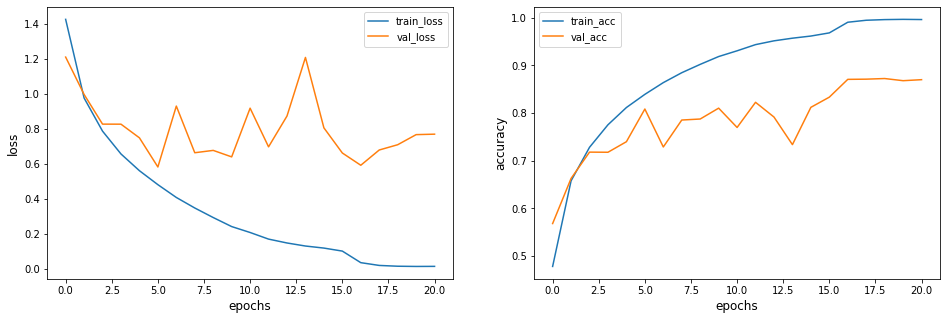

In [ ]:
show_history(history)

### **5-2. Evaluate the model**

In [ ]:
model_al_gap.evaluate(test_x, test_y_ohe)

313/313 [==============================] - 2s 5ms/step - loss: 0.7721 - accuracy: 0.8620


[0.7720977067947388, 0.8619999885559082]